## libraries

In [136]:
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest

# Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# DBSCAN
from sklearn.cluster import DBSCAN

## Data

In [137]:
df = pd.read_csv('../creditcard.csv')

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df = df.sample(frac=1)  #shuffle


# undersampling
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
df_un = normal_distributed_df.sample(frac=1, random_state=42)

# oversampling with SMOTE
sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(df.drop('Class', axis=1), df['Class'])

In [138]:
X_sm.shape, y_sm.shape

((568630, 30), (568630,))

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 30), (199364,), (85443, 30), (85443,))

In [140]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(df_un.drop('Class', axis=1), df_un['Class'], test_size=0.3, random_state=42)
X_train_un.shape, y_train_un.shape, X_test_un.shape, y_test_un.shape

((688, 30), (688,), (296, 30), (296,))

In [141]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
X_train_ov.shape, y_train_ov.shape, X_test_ov.shape, y_test_ov.shape

((398041, 30), (398041,), (170589, 30), (170589,))

# all model

In [159]:
all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

res = pd.DataFrame(index=all_model.keys(), columns=['accuracy', 'f1score_micro', 'f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res['accuracy'][key] = accuracy_score(y_test, y_pred)
    res['f1score_micro'][key] = f1_score(y_test, y_pred, average='micro')
    res['f1score_weighted'][key] = f1_score(y_test, y_pred, average='weighted')
    res['rocauc'][key] = roc_auc_score(y_test, y_pred)
    print(key, 'done')

LogisticRegression done


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


KNearest done
Support Vector Classifier done
Naive Bayes done
DecisionTreeClassifier done
randomforest done


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


isolationforest done
extratree done


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


adaboost done
gradientboost done


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost done
lgbm done
Learning rate set to 0.098829
0:	learn: 0.3777227	total: 21.2ms	remaining: 21.2s
1:	learn: 0.2028386	total: 42.3ms	remaining: 21.1s
2:	learn: 0.1186012	total: 63.5ms	remaining: 21.1s
3:	learn: 0.0670263	total: 83.1ms	remaining: 20.7s
4:	learn: 0.0401912	total: 101ms	remaining: 20.2s
5:	learn: 0.0249013	total: 119ms	remaining: 19.8s
6:	learn: 0.0168899	total: 137ms	remaining: 19.5s
7:	learn: 0.0117032	total: 155ms	remaining: 19.2s
8:	learn: 0.0088571	total: 173ms	remaining: 19s
9:	learn: 0.0069834	total: 190ms	remaining: 18.8s
10:	learn: 0.0057774	total: 208ms	remaining: 18.7s
11:	learn: 0.0049609	total: 227ms	remaining: 18.6s
12:	learn: 0.0043942	total: 244ms	remaining: 18.5s
13:	learn: 0.0040155	total: 263ms	remain

In [161]:
res.to_csv('result.csv')

In [162]:
all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

undersampling_res = pd.DataFrame(index=all_model.keys(), columns=['accuracy', 'f1score_micro', 'f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train_un, y_train_un)
    y_pred_un = model.predict(X_test_un)
    undersampling_res['accuracy'][key] = accuracy_score(y_test_un, y_pred_un)
    undersampling_res['f1score_micro'][key] = f1_score(y_test_un, y_pred_un, average='micro')
    undersampling_res['f1score_weighted'][key] = f1_score(y_test_un, y_pred_un, average='weighted')
    undersampling_res['rocauc'][key] = roc_auc_score(y_test_un, y_pred_un)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers star

[09:36:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.008782
0:	learn: 0.6779805	total: 2.71ms	remaining: 2.7s
1:	learn: 0.6667800	total: 5.51ms	remaining: 2.75s
2:	learn: 0.6556414	total: 7.61ms	remaining: 2.53s
3:	learn: 0.6449799	total: 9.74ms	remaining: 2.42s
4:	learn: 0.6350212	total: 11.8ms	remaining: 2.35s
5:	learn: 0.6228943	total: 14ms	remaining: 2.31s
6:	learn: 0.6126449	total: 16.1ms	remaining: 2.28s
7:	learn: 0.6017318	total: 18.2ms	remaining: 2.25s
8:	learn: 0.5919649	total: 20.2ms	remaining: 2.23s
9:	learn: 0.5810589	total: 22.3ms	remaining: 2.21s
10:	learn: 0.5715392	total: 24.4ms	remaining: 2.19s
11:	learn: 0.5619193	total: 26.5ms	remaining: 2.18s
12:	learn: 0.5531108	total: 28.6ms	remaining: 2.17s
13:	learn: 0.5436746	total: 30.7ms	remaining: 2.16s
14:

In [164]:
undersampling_res.to_csv('undersampling_res.csv')

In [167]:
all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

oversampling_res = pd.DataFrame(index=all_model.keys(), columns=['accuracy', 'f1score_micro', 'f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train_ov, y_train_ov)
    y_pred_ov = model.predict(X_test_ov)
    oversampling_res['accuracy'][key] = accuracy_score(y_test_ov, y_pred_ov)
    oversampling_res['f1score_micro'][key] = f1_score(y_test_ov, y_pred_ov, average='micro')
    oversampling_res['f1score_weighted'][key] = f1_score(y_test_ov, y_pred_ov, average='weighted')
    oversampling_res['rocauc'][key] = roc_auc_score(y_test_ov, y_pred_ov)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers star

[13:22:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.132771
0:	learn: 0.4481959	total: 51.4ms	remaining: 51.4s
1:	learn: 0.3362634	total: 97.2ms	remaining: 48.5s
2:	learn: 0.2494938	total: 143ms	remaining: 47.5s
3:	learn: 0.2094533	total: 178ms	remaining: 44.3s
4:	learn: 0.1793917	total: 212ms	remaining: 42.1s
5:	learn: 0.1568757	total: 245ms	remaining: 40.5s
6:	learn: 0.1433846	total: 277ms	remaining: 39.3s
7:	learn: 0.1317867	total: 310ms	remaining: 38.4s
8:	learn: 0.1227353	total: 344ms	remaining: 37.9s
9:	learn: 0.1162740	total: 377ms	remaining: 37.3s
10:	learn: 0.1093216	total: 410ms	remaining: 36.8s
11:	learn: 0.1043454	total: 441ms	remaining: 36.3s
12:	learn: 0.0987314	total: 470ms	remaining: 35.7s
13:	learn: 0.0926839	total: 500ms	remaining: 35.2s
14:	learn: 0

In [166]:
oversampling_res

,accuracy,f1score_micro,f1score_weighted,rocauc
LogisticRegression,0.949024,0.947677,0.947677,0.949077
KNearest,0.998787,0.99879,0.99879,0.998784
Support Vector Classifier,0.977742,0.977609,0.977609,0.977757
Naive Bayes,0.914426,0.909075,0.909075,0.914544
DecisionTreeClassifier,0.997942,0.997948,0.997948,0.997941
randomforest,0.999877,0.999877,0.999877,0.999877
isolationforest,0.392305,NaN,NaN,NaN
extratree,NaN,NaN,NaN,NaN
adaboost,NaN,NaN,NaN,NaN
gradientboost,NaN,NaN,NaN,NaN


In [168]:
oversampling_res.to_csv('oversampling_res.csv')

In [169]:
oversampling_res

,accuracy,f1score_micro,f1score_weighted,rocauc
LogisticRegression,0.949024,0.949024,0.948987,0.949077
KNearest,0.998787,0.998787,0.998787,0.998784
Support Vector Classifier,0.977742,0.977742,0.977741,0.977757
Naive Bayes,0.914426,0.914426,0.914119,0.914544
DecisionTreeClassifier,0.997925,0.997925,0.997925,0.997923
randomforest,0.999889,0.999889,0.999889,0.999888
isolationforest,0.387082,0.387082,0.280617,0.391349
extratree,0.999889,0.999889,0.999889,0.999888
adaboost,0.961316,0.961316,0.96131,0.961344
gradientboost,0.977437,0.977437,0.977435,0.977455


# Classifier

In [19]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "training score:", training_score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression training score: 0.9991773839303351
KNeighborsClassifier training score: 0.9993980861647449
SVC training score: 0.9993479267833075
DecisionTreeClassifier training score: 0.9990519845332365


In [20]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train_un, y_train_un)
    training_score = cross_val_score(classifier, X_train_un, y_train_un, cv=5)
    print(classifier.__class__.__name__, "undersampling training score:", training_score.mean())

LogisticRegression undersampling training score: 0.9360837829260552
KNeighborsClassifier undersampling training score: 0.9331746535491379
SVC undersampling training score: 0.9360732042737755
DecisionTreeClassifier undersampling training score: 0.9113508938961177


In [32]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train_ov, y_train_ov)
    training_score = cross_val_score(classifier, X_train_ov, y_train_ov, cv=5)
    print(classifier.__class__.__name__, "oversampling training score:", training_score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression oversampling training score: 0.9486861891655854
KNeighborsClassifier oversampling training score: 0.9984574457550737
SVC oversampling training score: 0.9743091790719646
DecisionTreeClassifier oversampling training score: 0.9973419818977856


# Boosting
여러개의 학습모형을 연결하여 앞의 모형을 보완해 가면서 뒤로 갈수록 더욱 강한 모형을 만듬

In [27]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__, "accuracy score:", accuracy_score(y_test, y_pred))

AdaBoostClassifier accuracy score: 0.9990988144142879
GradientBoostingClassifier accuracy score: 0.9984785178423042


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier accuracy score: 0.9996371850239341
LGBMClassifier accuracy score: 0.9970389616469459
Learning rate set to 0.098829
0:	learn: 0.3783056	total: 21.4ms	remaining: 21.3s
1:	learn: 0.2036131	total: 40.2ms	remaining: 20.1s
2:	learn: 0.1190872	total: 59.8ms	remaining: 19.9s
3:	learn: 0.0683784	total: 78.1ms	remaining: 19.5s
4:	learn: 0.0406517	total: 95.8ms	remaining: 19.1s
5:	learn: 0.0261772	total: 115ms	remaining: 19.1s
6:	learn: 0.0179714	total: 135ms	remaining: 19.2s
7:	learn: 0.0124391	total: 153ms	remaining: 18.9s
8:	learn: 0.0091574	total: 170ms	remaining: 18.7s
9:	learn: 0.0072396	total: 188ms	remaining: 18.6s
10:	learn: 0.0060337	total: 205ms	remaining: 18.4s
11:	learn: 0.0052480	total: 223ms	remaining: 18.3s
12:	learn: 0

In [29]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train_un, y_train_un)
    y_pred_un = model.predict(X_test_un)
    print(model.__class__.__name__, "undersampling accuracy score:", accuracy_score(y_test_un, y_pred_un))

AdaBoostClassifier undersampling accuracy score: 0.9222972972972973
GradientBoostingClassifier undersampling accuracy score: 0.918918918918919


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier undersampling accuracy score: 0.9290540540540541
LGBMClassifier undersampling accuracy score: 0.9391891891891891
Learning rate set to 0.008782
0:	learn: 0.6800411	total: 2.2ms	remaining: 2.2s
1:	learn: 0.6690439	total: 4.35ms	remaining: 2.17s
2:	learn: 0.6583557	total: 6.59ms	remaining: 2.19s
3:	learn: 0.6458040	total: 8.92ms	remaining: 2.22s
4:	learn: 0.6359168	total: 11.4ms	remaining: 2.27s
5:	learn: 0.6239139	total: 13.8ms	remaining: 2.28s
6:	learn: 0.6146021	total: 16.4ms	remaining: 2.33s
7:	learn: 0.6051881	total: 74ms	remaining: 9.18s
8:	learn: 0.5946728	total: 76.8ms	remaining: 8.46s
9:	learn: 0.5846861	total: 79.5ms	remaining: 7.87s
10:	learn: 0.5744101	total: 82.2ms	remaining: 7.39s
11:	learn: 0.5636908	total: 84.8m

In [31]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train_ov, y_train_ov)
    y_pred_ov = model.predict(X_test_ov)
    print(model.__class__.__name__, "oversampling accuracy score:", accuracy_score(y_test_ov, y_pred_ov))

AdaBoostClassifier oversampling accuracy score: 0.963432577716031
GradientBoostingClassifier oversampling accuracy score: 0.9773021707144072


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier oversampling accuracy score: 0.9997127599083176
LGBMClassifier oversampling accuracy score: 0.9991617278957026
Learning rate set to 0.132771
0:	learn: 0.4451222	total: 39.4ms	remaining: 39.4s
1:	learn: 0.3178347	total: 75ms	remaining: 37.4s
2:	learn: 0.2504344	total: 110ms	remaining: 36.4s
3:	learn: 0.2097651	total: 158ms	remaining: 39.2s
4:	learn: 0.1783689	total: 207ms	remaining: 41.2s
5:	learn: 0.1563298	total: 253ms	remaining: 41.8s
6:	learn: 0.1447263	total: 285ms	remaining: 40.5s
7:	learn: 0.1321922	total: 319ms	remaining: 39.6s
8:	learn: 0.1240147	total: 351ms	remaining: 38.6s
9:	learn: 0.1150110	total: 387ms	remaining: 38.3s
10:	learn: 0.1085812	total: 419ms	remaining: 37.7s
11:	learn: 0.1016020	total: 452ms	remainin

## AdaBoost
- 이전 모형을 보완하여 새로운 모형을 만드는 방법의 기본은 이전 모형이 잘 맞추지 못한 데이터에 대해 가중치를 더 높임
- 새로운 모형은 가중치가 더 높은 데이터를 잘 구분하려고 하므로 어려운 데이터를 점점 더 잘 분류할 수 있게 됨
- 단점: Bagging이나 Pating처럼 병렬화가 안됨

In [26]:
ada_clf = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200, 
    algorithm="SAMME.R", 
    learning_rate=0.5 
)
ada_clf.fit(X_train, y_train) 

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9993562960102056

## Gradient Boost
이전 모형이 만든 잔여 오차에 대한 새로운 모형을 학습시킴

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## 확률적 그래디언트 부스트 (Stochastic Gradient Boost)
- 그래디언트 부스트 방안이 트리를 학습할때 사용할 학습 데이터의 비율 지정
- 데이터를 무작위로 뽑아서 학습

## XGBOOST

In [ ]:
xgb_clf = xgboost.XGBClassifier(max_depth=2, eta=1)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## lightGBM

In [ ]:
lgb_clf = lightgbm.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

y_pred = lgb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## CATBOOST

In [ ]:
cat_clf = catboost.CatBoostClassifier()
cat_clf.fit(X_train, y_train)

y_pred = cat_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Bagging

In [53]:
bag_clf = BaggingClassifier(
    LogisticRegression(max_iter=100000), 
    n_estimators = 500, 
    max_samples = 100, 
    bootstrap = True, 
    n_jobs = -1
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9982444436641972

In [ ]:
bag_clf = BaggingClassifier()
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Random Forest

In [56]:
rnd_clf = RandomForestClassifier(
    n_estimators = 500,  
    max_features = 'auto', 
    max_samples=0.5,    
    bootstrap = True,
    n_jobs=-1
)

rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9994850368081645

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Isolation Forest

In [188]:
iforest = IsolationForest()

iforest.fit(X_train, y_train)

y_pred = iforest.predict(X_test)
y_pred = [1 if x==-1 else 0 for x in y_pred]
print('accuracy:', accuracy_score(y_test, y_pred))
print('f1score micro:', f1_score(y_test, y_pred, average='micro'))
print('f1score weighted:', f1_score(y_test, y_pred, average='weighted'))
print('rocauc:', roc_auc_score(y_test, y_pred))

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


accuracy: 0.9634142059618693
f1score micro: 0.9634142059618693
f1score weighted: 0.979837775464365
rocauc: 0.9073318726906205


In [189]:
iforest = IsolationForest()

iforest.fit(X_train_un, y_train_un)

y_pred_un = iforest.predict(X_test_un)
y_pred_un = [1 if x==-1 else 0 for x in y_pred_un]
print('accuracy:', accuracy_score(y_test_un, y_pred_un))
print('f1score micro:', f1_score(y_test_un, y_pred_un, average='micro'))
print('f1score weighted:', f1_score(y_test_un, y_pred_un, average='weighted'))
print('rocauc:', roc_auc_score(y_test_un, y_pred_un))

accuracy: 0.5878378378378378
f1score micro: 0.5878378378378378
f1score weighted: 0.5351616640679142
rocauc: 0.6215220195319698


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [190]:
iforest = IsolationForest()

iforest.fit(X_train_ov, y_train_ov)

y_pred_ov = iforest.predict(X_test_ov)
y_pred_ov = [1 if x==-1 else 0 for x in y_pred_ov]
print('accuracy:', accuracy_score(y_test_ov, y_pred_ov))
print('f1score micro:', f1_score(y_test_ov, y_pred_ov, average='micro'))
print('f1score weighted:', f1_score(y_test_ov, y_pred_ov, average='weighted'))
print('rocauc:', roc_auc_score(y_test_ov, y_pred_ov))

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


accuracy: 0.6170737855313062
f1score micro: 0.6170737855313062
f1score weighted: 0.5561024844051685
rocauc: 0.6177936044045674


## Extra tree

In [66]:
et_clf = ExtraTreesClassifier(
    n_estimators = 500, 
    max_leaf_nodes = 16, 
    max_features = 'auto', 
    n_jobs=-1
)

et_clf.fit(X_train, y_train)

y_pred = et_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9988530365272755

In [ ]:
et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)

y_pred = et_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

# Deep Learning

In [46]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [47]:
n_inputs = X_train.shape[1]

model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
pred = model.predict_classes(X_test, batch_size=200, verbose=0)

print('accuracy:', accuracy_score(y_test, pred))

Epoch 1/20
6380/6380 - 15s - loss: 0.0073 - accuracy: 0.9990 - val_loss: 0.0041 - val_accuracy: 0.9992
Epoch 2/20
6380/6380 - 15s - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 3/20
6380/6380 - 14s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0047 - val_accuracy: 0.9992
Epoch 4/20
6380/6380 - 14s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 5/20
6380/6380 - 15s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 6/20
6380/6380 - 14s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0046 - val_accuracy: 0.9991
Epoch 7/20
6380/6380 - 14s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0045 - val_accuracy: 0.9992
Epoch 8/20
6380/6380 - 15s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0046 - val_accuracy: 0.9993
Epoch 9/20
6380/6380 - 15s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 10/20
6380/6380 - 15s - loss: 0.0019 - accuracy: 0.9995 - val_loss:

In [48]:
n_inputs = X_train_un.shape[1]

under_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

under_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
under_model.fit(X_train_un, y_train_un, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
under_pred = under_model.predict_classes(X_test_un, batch_size=200, verbose=0)

print('undersampling_accuracy:', accuracy_score(y_test_un, under_pred))

Epoch 1/20
22/22 - 0s - loss: 0.8290 - accuracy: 0.6055 - val_loss: 0.4757 - val_accuracy: 0.6957
Epoch 2/20
22/22 - 0s - loss: 0.4403 - accuracy: 0.7818 - val_loss: 0.3885 - val_accuracy: 0.7826
Epoch 3/20
22/22 - 0s - loss: 0.3455 - accuracy: 0.8909 - val_loss: 0.3178 - val_accuracy: 0.8696
Epoch 4/20
22/22 - 0s - loss: 0.2777 - accuracy: 0.9236 - val_loss: 0.2746 - val_accuracy: 0.9058
Epoch 5/20
22/22 - 0s - loss: 0.2335 - accuracy: 0.9309 - val_loss: 0.2446 - val_accuracy: 0.9203
Epoch 6/20
22/22 - 0s - loss: 0.2012 - accuracy: 0.9345 - val_loss: 0.2257 - val_accuracy: 0.9275
Epoch 7/20
22/22 - 0s - loss: 0.1793 - accuracy: 0.9418 - val_loss: 0.2155 - val_accuracy: 0.9348
Epoch 8/20
22/22 - 0s - loss: 0.1635 - accuracy: 0.9418 - val_loss: 0.2079 - val_accuracy: 0.9420
Epoch 9/20
22/22 - 0s - loss: 0.1480 - accuracy: 0.9455 - val_loss: 0.2052 - val_accuracy: 0.9420
Epoch 10/20
22/22 - 0s - loss: 0.1374 - accuracy: 0.9473 - val_loss: 0.2016 - val_accuracy: 0.9420
Epoch 11/20
22/22 -

In [49]:
n_inputs = X_train_ov.shape[1]

over_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

over_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
over_model.fit(X_train_ov, y_train_ov, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)
over_pred = over_model.predict_classes(X_test_ov, batch_size=200, verbose=0)

print('oversampling_accuracy:', accuracy_score(y_test_ov, over_pred))

Epoch 1/20
1062/1062 - 3s - loss: 0.0872 - accuracy: 0.9649 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 2/20
1062/1062 - 3s - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0132 - val_accuracy: 0.9966
Epoch 3/20
1062/1062 - 2s - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 4/20
1062/1062 - 3s - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.0064 - val_accuracy: 0.9984
Epoch 5/20
1062/1062 - 3s - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 0.9988
Epoch 6/20
1062/1062 - 3s - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0049 - val_accuracy: 0.9989
Epoch 7/20
1062/1062 - 2s - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 8/20
1062/1062 - 3s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 9/20
1062/1062 - 3s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 10/20
1062/1062 - 2s - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0035 - 

# Mixture Model

In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

In [42]:
gm = GaussianMixture(n_components=2, random_state=42).fit(X_train)
pred = gm.predict(X_test)
accuracy_score(y_test, pred)

0.6287466498133258

In [43]:
gm_un = GaussianMixture(n_components=2, random_state=42).fit(X_train_un)
pred_un = gm_un.predict(X_test_un)
accuracy_score(y_test_un, pred_un)

0.6587837837837838

In [44]:
gm_ov = GaussianMixture(n_components=2, random_state=42).fit(X_train_ov)
pred_ov = gm_ov.predict(X_test_ov)
accuracy_score(y_test_ov, pred_ov)

0.3377357273915669

In [38]:
bgm = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train)
pred = bgm.predict(X_test)
accuracy_score(y_test, pred)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


0.6248142036211275

In [40]:
bgm_un = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train_un)
pred_un = bgm_un.predict(X_test_un)
accuracy_score(y_test_un, pred_un)

0.6452702702702703

In [41]:
bgm_ov = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train_ov)
pred_ov = bgm_ov.predict(X_test_ov)
accuracy_score(y_test_ov, pred_ov)

0.33706745452520387

## scatter Gaussian Mixture

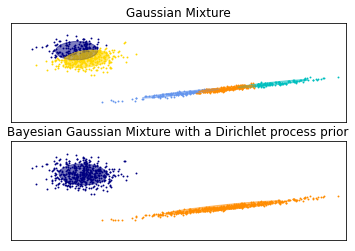

In [88]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()